# Simple Machine-Learning: Boosted Regression Predictions
**Author:** Eli Holmes (NOAA)</br>
Last updated: November 19, 2025

[![Colab Badge](https://img.shields.io/badge/Open_in_Colab-blue?style=for-the-badge)][colab-link]
<a href="javascript:void(0);" onclick="openJupyterWidget('https://github.com/fish-pace/2025-tutorials/blob/main/BRT_2D.ipynb');">
    <img src="https://img.shields.io/badge/Open_in_JupyterHub-orange?style=for-the-badge" alt="JupyterHub Badge">
</a> [![Download Badge](https://img.shields.io/badge/Download-grey?style=for-the-badge)][download-link] [![JupyterHub](https://img.shields.io/badge/Workshop_Hub-green?style=for-the-badge)][jupyter-link]

[download-link]: https://github.com/fish-pace/2025-tutorials/blob/main/BRT_2D.ipynb
[colab-link]: https://colab.research.google.com/github/fish-pace/2025-tutorials/blob/main/BRT_2D.ipynb
[jupyter-link]: https://workshop.nmfs-openscapes.2i2c.cloud/hub/user-redirect/lab?fromURL=https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/BRT_2D.ipynb

>📘 Learning Objectives
>
> 1. Understand the basics of prediction
> 2. Learn the format that your training data should be in
> 3. Learn to fit a Boosted Regression Tree
> 4. Evaluate fit
> 5. Make predictions with your model

::: {.callout-important}
# Important notes for this tutorial

### The functions are in a separate file

The Python functions for doing tasks, like prepping the data and plotting, are in a separate file `ml_utils.py` and the functions are imported with `import ml_utils as mu`. You will need to run the import code to have access to the functions.
:::

## Summary

In this tutorial we will predict a numerical variable (chl) using predictor variables, in this case SST, salinity, and season.

$$
\hat{y} \sim f(sst, so, season, location)
$$

We will use a classic non-linear prediction model: boosted regression trees (BRTs). Trees learn a big collection of if-else rules that split the response variable space. BRTs are non-linear: they can learn complicated non-linear relationships like “very high CHL only occurs when SST is low and it’s winter and we are above a certain latitude threshold.” They can handle complex interactions between variables (SST × salinity × season × location).

The goal is to create a predicted map of CHL given our predictor variables on a given day.

![BRT pred map](./Supporting_files/y_pred.png)

## Overview of the modeling steps

1. Create your sampling dataframe: spatial samples with response (what you are trying to predict), latitude, longitude, date.
2. Create your predictor dataframe. In this example we have an 3D cube (time, lat, lon) with all the variables and we sample from that.
3. Fit model
5. Make predictions

The hard part is the data prep. We need a dataframe that looks like this. Just showing the first 5 samples. `y` is what we are predicting and it is the true values we have (from some type of observation) and the variables to the right are what we train on. The ocean mask just tells up what to ignore (it's land).

| time       | lat   | lon   | y      | sst   | so    | sin_time | cos_time | x_geo | y_geo | z_geo  | ocean_mask |
| ---------- | ----- | ----- | ------ | ----- | ----- | -------- | -------- | ----- | ----- | ------ | ---------- |
| 2020-07-03 | 12.25 | 63.50 | -1.273 | 27.84 | 34.82 | 0.017    | 1.000    | 0.431 | 0.904 | 0.212  | 1          |
| 2020-01-15 | 28.75 | 74.25 | -0.522 | 24.11 | 35.21 | -0.142   | -0.990   | 0.257 | 0.932 | 0.482  | 1          |
| 2020-03-28 | -2.00 | 88.75 | -2.004 | 29.47 | 34.55 | 0.651    | 0.759    | 0.030 | 0.999 | -0.035 | 1          |
| 2020-10-09 | 5.75  | 59.25 | -1.618 | 26.33 | 34.90 | -0.843   | 0.538    | 0.504 | 0.863 | 0.100  | 1          |
| 2020-12-22 | 17.50 | 46.50 | -0.931 | 22.88 | 35.40 | -0.149   | -0.989   | 0.675 | 0.737 | 0.300  | 1          |


## Variables in the model

A nice thing about BRTs is that we do not need to normalize (standardize) our predictor variables. BRTs work by splitting our predictors and normalizing has no effect. This is different than many other types of models that will perform much better with normalization.

| Feature        | Spatial Variation       | Temporal Variation | Notes                             |
|----------------|-------------------------|--------------------|-----------------------------------|
| `sst`, `so`        | ✅ Varies by lat/lon     | ✅ Varies by time   | Numeric                |
| `sin_time`, `cos_time` | ❌ Same across lat/lon   | ✅ Varies by time   | Cyclical |
| `x_geo`,`y_geo`, `z_geo` | ✅ Varies by lat/lon   |❌ Static   | -1 to 1    |
| `ocean_mask`   | ✅ Varies by lat/lon     | ❌ Static           | Binary (0=land, 1=ocean) |
| `y` (log CHL) | ✅ Varies by lat/lon     | ✅ Varies by time   | Numeric  |


- **`sst` and `so`**: These are our core predictor variables. 
  
- **`sin_time` and `cos_time`**: These introduce seasonality into our model. The models can learn seasonally dependent patterns, e.g., chlorophyll blooms in spring. The `sin_time` and `cos_time` features use cyclical encoding (sine/cosine). 

- **`x_geo`, `y_geo`, and `z_geo`**: This is a dimensionless geometric encoding of location on the globe that is -1 to 1. This works better than lat/lon for machine-learning tasks. Including these location variables allows the model to learn location specific relationships.

- **`ocean_mask`**: This tells the model which pixels are land (0) vs ocean (1).

- **`y` (response)**: The model trains on this. For our model it is logged CHL and it is roughly centered near 0.


*Note, neither bathymetry nor distance from coast improved the model by any appreciable amount over the model we use here. SST (upwelling signal) and salinity (river outflow signal) are highly correlated with chlorophyll in this region with strong seasonal patterns.* 


## Dealing with NaNs

In our application, NaNs in y (in our case CHL) appear over land and when obscured by clouds. Our BRT fitting function needs us to remove any rows in our dataframe where y is NaN. NaNs in our predictor variables are less common, but can happen. BRTs functions typically filter out any training data that have NaNs in the predictor variables so we will ignore those NaNs. We just have to make sure that missing values, or areas to ignore like land or cloud are coded as NaN and not something like -99.


## Load the libraries

* core data handling and plotting libraries
* our custom functions in `ml_utils.py`

In [3]:
# Uncomment this line and run if you are in Colab; leave in the !. That is part of the cmd
# !pip install zarr gcsfs --quiet

In [95]:
# --- Core data handling and plotting libraries ---
import xarray as xr       # for working with labeled multi-dimensional arrays
import numpy as np        # for numerical operations on arrays
import matplotlib.pyplot as plt  # for creating plots

In [96]:
# --- Custom python functions ---
# this requires that tensorflow and keras are available
import os, importlib
# Looks to see if you have the file already and if not, downloads from GitHub
if not os.path.exists("ml_utils.py"):
    !wget -q https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/ml_utils.py

import ml_utils as mu
importlib.reload(mu)

<module 'ml_utils' from '/home/jovyan/2025-tutorials/ml_utils.py'>

# Prepare the Indian Ocean Dataset

This is a dataset for the Indian Ocean with a variety of variables, including chlorophyll which will will try to predict using SST, salinity, location and season. The data are in Google Object Storage as a chunked Zarr file. It has files that are chunks of 100 days of data. When we go to get data we will get these files. How we load our data will determine if our xarray dataset "knows" about the chunks and this will make a big difference to speed and memory usage.  `xarray.open_dataset` will not know the chunking while `xarray.open_zarr` will.


In [97]:
# Load the Indian Ocean Dataset
# Note use open_zarr instead of open_dataset to preserve the chunking
data_full = xr.open_zarr(
    "gcs://nmfs_odp_nwfsc/CB/mind_the_chl_gap/IO.zarr", 
    storage_options={"token": "anon"}, 
    consolidated=True
)
# slice to a smaller lat/lon segment
data_full = data_full.sel(lat=slice(35, -5), lon=slice(45,90))

# subset out predictors, response and land mask
pred_var = ["sst", "so"]
resp_var = "CHL_cmes-gapfree"
land_mask = "CHL_cmes-land"
dataset = data_full[pred_var + [resp_var, land_mask]]
dataset = dataset.rename({resp_var: "y", land_mask: "land_mask"})

# IMPORTANT! log our response so it is symmetric (Normal-ish)
dataset["y"] = np.log(dataset["y"])

# remove years with no response (y), sst or salinity data; these will be all NaN
vars_to_check = ["y", "so", "sst"]
drop = dataset[vars_to_check].to_array().isnull().all(["lat", "lon"]).any("variable")
dataset = dataset.sel(time=~drop)

# Make ocean mask
# Mark where SST (sea surface temperature) is always missing; these are likely lakes
dataset["land_mask"] = dataset["land_mask"] == 0 # make ocean 1 instead of land
invalid_ocean = np.isnan(dataset["sst"]).all(dim="time") 
dataset["land_mask"] = dataset["land_mask"].where(~invalid_ocean, other=False)
dataset = dataset.rename({"land_mask": "ocean_mask"})

# Add location and seasonality variables
dataset = mu.add_spherical_coords(dataset)  # add lat/lon variables to dataset
dataset = mu.add_seasonal_time_features(dataset)

# fix chunking to be consistent
dataset = dataset.chunk({'time': 100, 'lat': -1, 'lon': -1})

dataset

<xarray.Dataset> Size: 5GB
Dimensions:     (time: 8475, lat: 149, lon: 181)
Coordinates:
  * lat         (lat) float32 596B 32.0 31.75 31.5 31.25 ... -4.5 -4.75 -5.0
  * lon         (lon) float32 724B 45.0 45.25 45.5 45.75 ... 89.5 89.75 90.0
  * time        (time) datetime64[ns] 68kB 1997-10-01 1997-10-02 ... 2020-12-31
Data variables:
    sst         (time, lat, lon) float32 914MB dask.array<chunksize=(100, 149, 181), meta=np.ndarray>
    so          (time, lat, lon) float32 914MB dask.array<chunksize=(100, 149, 181), meta=np.ndarray>
    y           (time, lat, lon) float32 914MB dask.array<chunksize=(100, 149, 181), meta=np.ndarray>
    ocean_mask  (lat, lon) bool 27kB dask.array<chunksize=(149, 181), meta=np.ndarray>
    x_geo       (lat, lon) float32 108kB dask.array<chunksize=(149, 181), meta=np.ndarray>
    y_geo       (lat, lon) float32 108kB dask.array<chunksize=(149, 181), meta=np.ndarray>
    z_geo       (lat, lon) float32 108kB dask.array<chunksize=(149, 181), meta=np.ndarray>
    sin_time    (time, lat, lon) float32 914MB dask.array<chunksize=(100, 149, 181), meta=np.ndarray>
    cos_time    (time, lat, lon) float32 914MB dask.array<chunksize=(100, 149, 181), meta=np.ndarray>
Attributes: (12/92)
    Conventions:                     CF-1.8, ACDD-1.3
    DPM_reference:                   GC-UD-ACRI-PUG
    IODD_reference:                  GC-UD-ACRI-PUG
    acknowledgement:                 The Licensees will ensure that original ...
    citation:                        The Licensees will ensure that original ...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L3_MY_009_103
    ...                              ...
    time_coverage_end:               2024-04-18T02:58:23Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2024-04-16T21:12:05Z
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l3-mult...
    westernmost_longitude:           -180.0
    westernmost_valid_longitude:     -180.0

## Create random sample of log CHL from the Indian Ocean dataset

For this tutorial, we will create our observations by sampling from our dataset but in practice you would have a separate observation dataset from some sampling scheme. Note when working with cloud native data (meaning optimized for reading by chunking), you do not want to do something like a for loop. You need to use more a move clever approach so that you minimize the calls to the cloud dataset (because reading is the slow part). For learning, you don't really have to care about this as long as you use toy examples but once you are trying to get data for 1000s of points, you do.

For this example, we will train on sample data from 2020 and apply that to predictions in other years.

In [98]:
import numpy as np
import pandas as pd
import xarray as xr

def sample_points_fast(
    ds: xr.Dataset,
    year: int,
    n: int,
    y_name: str = "y",
    mask_var: str = "ocean_mask",
    seed: int = 42,
):
    """
    Vectorized random sampler for chunked xarray/dask datasets (no loops).

    - Draws n random times from ds.sel(time=year)
    - Draws n random *continuous* lat/lon within the coord ranges
    - Snaps those lat/lon to the nearest grid cell (vectorized)
    - Gathers y and mask using a single dask vindex, sets y=NaN where mask==False
    - Returns only rows with finite y

    Returns
    -------
    pd.DataFrame with columns: ['time','lat','lon','y']
      - 'lat','lon' are the original random (continuous) coordinates
        (y is taken from the nearest grid cell).
    """
    import dask.array as da  # local import to keep dependencies scoped

    dsy = ds.sel(time=str(year))
    if dsy.sizes.get("time", 0) == 0:
        raise ValueError(f"No timesteps found for year {year}.")

    rng = np.random.default_rng(seed)

    # ----- random time indices -----
    T = dsy.sizes["time"]
    t_idx = rng.integers(0, T, size=n)

    # ----- random continuous lat/lon, then snap to nearest grid index -----
    lat_vals = dsy["lat"].values
    lon_vals = dsy["lon"].values

    lat_rand = rng.uniform(lat_vals.min(), lat_vals.max(), size=n)
    lon_rand = rng.uniform(lon_vals.min(), lon_vals.max(), size=n)

    # searchsorted-based nearest-index that works for ascending or descending arrays
    def nearest_index(coord_vals, q):
        asc = coord_vals[0] <= coord_vals[-1]
        base = coord_vals if asc else -coord_vals
        tgt  = q          if asc else -q
        idx = np.searchsorted(base, tgt, side="left")
        idx0 = np.clip(idx - 1, 0, len(coord_vals) - 1)
        idx1 = np.clip(idx,     0, len(coord_vals) - 1)
        pick_right = np.abs(coord_vals[idx1] - q) < np.abs(coord_vals[idx0] - q)
        return np.where(pick_right, idx1, idx0)

    lat_i = nearest_index(lat_vals, lat_rand)
    lon_i = nearest_index(lon_vals, lon_rand)

    # ----- vindex gather for y and mask (single compute) -----
    y_da = dsy[y_name].data  # (time, lat, lon) dask array
    y_s  = y_da.vindex[t_idx, lat_i, lon_i]  # (n,)

    m_da = dsy[mask_var]
    if "time" in m_da.dims:
        m_s = m_da.data.vindex[t_idx, lat_i, lon_i]
    else:
        m_s = m_da.data.vindex[lat_i, lon_i]

    y_np, m_np = da.compute(y_s, m_s)

    # apply mask: keep only ocean
    y_np = np.where(m_np.astype(bool), y_np, np.nan)

    # ----- assemble output; keep the random (continuous) lat/lon -----
    times = pd.to_datetime(dsy["time"].values[t_idx])
    df = pd.DataFrame(
        {"time": times,
         "lat":  lat_rand.astype(float),
         "lon":  lon_rand.astype(float),
         "y":    y_np.astype(float)}
    )

    return df.dropna(subset=["y"]).reset_index(drop=True)

In [99]:
y_train = sample_points_fast(dataset, 2020, 10000)

In [100]:
y_train.head(5)

,time,lat,lon,y
0,2020-02-02,3.071520,60.639974,-2.189335
1,2020-06-09,1.165537,81.301786,-2.116684
2,2020-06-07,-3.377244,67.206579,-2.658942
3,2020-11-10,11.264733,52.720775,-1.707955
4,2020-02-01,23.638891,59.068457,-0.833890


Here are where the samples in July land.

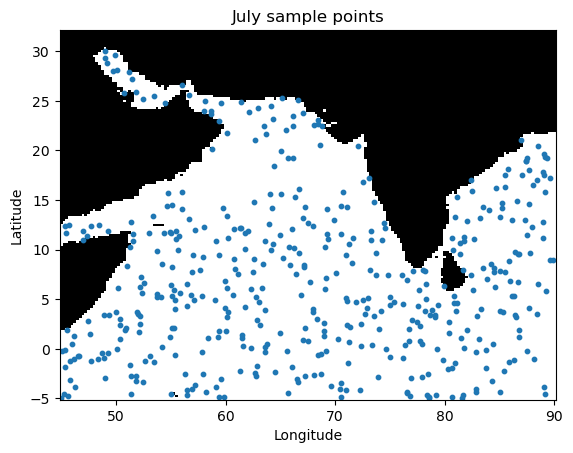

In [101]:
import pandas as pd
import matplotlib.pyplot as plt

ax = plt.gca()
dataset.ocean_mask.plot(ax=ax, cmap="gray", add_colorbar=False)
july = y_train[pd.to_datetime(y_train["time"]).dt.month == 7]
ax.scatter( july["lon"], july["lat"], s=10)
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
#ax.set_aspect("equal", adjustable="box")
ax.set_title("July sample points")
plt.show()

## Create the train-test dataset

We want all our variables plus the y. Here I create a function called `create_training_dataset()` that gets the predictor variables for our lat/lon/time samples and returns a dataframe.

In [102]:
# create_training_dataset function
import numpy as np
import pandas as pd
import xarray as xr

def create_training_dataset(
    ds: xr.Dataset,
    y_train: pd.DataFrame,
    num_var,
    cat_var,
):
    """
    Vectorized feature extraction at sampled points.

    Parameters
    ----------
    ds : xr.Dataset
        Must contain coords 'time','lat','lon' and the variables in num_var+cat_var.
    y_train : pd.DataFrame
        Columns: ['time','lat','lon'] (continuous lat/lon; time-like)
    num_var, cat_var : list[str]
        Predictor variable names. Can be:
          - (time,lat,lon)
          - (lat,lon)
          - (time,)
        Scalars are also supported (broadcast).

    Returns
    -------
    pd.DataFrame
        Columns: ['time','lat','lon'] + num_var + cat_var
        Values are gathered from the nearest grid cell/time stamp.
    """
    import dask.array as da

    # --- coordinate arrays from ds ---
    lat_vals  = ds["lat"].values
    lon_vals  = ds["lon"].values
    time_vals = np.asarray(ds["time"].values)  # datetime64

    # --- sample coordinates from y_train ---
    lat_rand  = np.asarray(y_train["lat"].values, dtype=float)
    lon_rand  = np.asarray(y_train["lon"].values, dtype=float)
    time_rand = pd.to_datetime(y_train["time"]).to_numpy(dtype="datetime64[ns]")

    # --- nearest-index helpers (work for ascending or descending) ---
    def nearest_index_1d(coord_vals, q_vals):
        asc = coord_vals[0] <= coord_vals[-1]
        base = coord_vals if asc else -coord_vals
        tgt  = q_vals     if asc else -q_vals
        idx  = np.searchsorted(base, tgt, side="left")
        idx0 = np.clip(idx - 1, 0, len(coord_vals) - 1)
        idx1 = np.clip(idx,     0, len(coord_vals) - 1)
        pick_right = np.abs(coord_vals[idx1] - q_vals) < np.abs(coord_vals[idx0] - q_vals)
        return np.where(pick_right, idx1, idx0)

    def nearest_time_index(times, qtimes):
        t = times.astype("datetime64[ns]").astype("int64")
        q = qtimes.astype("datetime64[ns]").astype("int64")
        idx  = np.searchsorted(t, q, side="left")
        idx0 = np.clip(idx - 1, 0, len(t) - 1)
        idx1 = np.clip(idx,     0, len(t) - 1)
        pick_right = np.abs(t[idx1] - q) < np.abs(t[idx0] - q)
        return np.where(pick_right, idx1, idx0)

    # --- build index vectors for each sample ---
    lat_i = nearest_index_1d(lat_vals,  lat_rand)
    lon_i = nearest_index_1d(lon_vals,  lon_rand)
    t_idx = nearest_time_index(time_vals, time_rand)

    # --- gather all predictors with dask vindex in one compute ---
    names = list(num_var) + list(cat_var)
    gathers = []
    for v in names:
        if v not in ds:
            raise KeyError(f"Variable '{v}' not found in dataset.")
        da_v = ds[v]
        dims = da_v.dims

        # reorder to a standard axis order before vindex
        if {"time","lat","lon"} <= set(dims):
            x = da_v.transpose("time","lat","lon")
            g = x.data.vindex[t_idx, lat_i, lon_i]
        elif {"lat","lon"} <= set(dims):
            x = da_v.transpose("lat","lon")
            g = x.data.vindex[lat_i, lon_i]
        elif ("time" in dims) and ("lat" not in dims) and ("lon" not in dims):
            x = da_v.transpose("time", ...)
            g = x.data.vindex[t_idx]
        elif da_v.ndim == 0:  # scalar → broadcast to length n
            g = da.asarray(np.full_like(t_idx, fill_value=float(da_v.values), dtype=float))
        else:
            raise ValueError(
                f"Unsupported dims for '{v}': {dims}. "
                "Expected (time,lat,lon), (lat,lon), (time,), or scalar."
            )
        gathers.append(g)

    # single materialization step
    values = da.compute(*gathers)

    # --- assemble output ---
    df = pd.DataFrame({
        "time": pd.to_datetime(time_vals[t_idx]),
        "lat":  lat_vals[lat_i].astype(float),
        "lon":  lon_vals[lon_i].astype(float),
        "y":  y_train["y"].astype(float),   
    })
    for v, arr in zip(names, values):
        df[v] = np.asarray(arr)

    return df

Create our training dataset. We will split into train and test.

In [103]:
num_var = ['sst','so']
cat_var = ['ocean_mask','sin_time','cos_time','x_geo', 'y_geo', 'z_geo']
train_dataset = create_training_dataset(dataset, y_train, num_var, cat_var)

## Fit a BRT

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# predictor variables
feat_cols = num_var + cat_var
df = train_dataset.copy()

# keep ocean & finite y. Only train on the ocean values.
if "ocean_mask" in df:
    df = df[df["ocean_mask"] > 0.5]
df = df[np.isfinite(df["y"])]

# get numpy arrays
X = df[feat_cols].to_numpy()  # may include NaNs — OK for HGBR
y = df["y"].to_numpy()

# create train and test split
X_train, X_test, y_train_vec, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# train the model
brt_model = HistGradientBoostingRegressor(
    max_depth=6, learning_rate=0.05, max_iter=400,
    validation_fraction=0.1, early_stopping=True, random_state=42
).fit(X_train, y_train_vec)

## Compare to the test data

In [105]:
pred = brt_model.predict(X_test)
print("R²:", r2_score(y_test, pred))
print("RMSE:", mean_squared_error(y_test, pred))

R²: 0.7850330403327634
RMSE: 0.15018093739608177


## Make a prediction of the whole region

To make a prediction, we use the `predict` attribute for the brt model object. It needs the predictor variables in rows rather than like a lat/lon map. Once we have the prediction, we can plot but we need to set the land to NaN otherwise our plot will show a prediction for land.


In [122]:
# pick your day (exact or nearest)
day = dataset.sel(time="2001-10-10")  # or: dataset.sel(time="2001-10-10", method="nearest")

# choose a template to broadcast to for vars that do not have lat/lon
tmpl = day["sst"]

# stack features into (H, W, C)
X_map = np.stack([(day[v].broadcast_like(tmpl)).values for v in (num_var + cat_var)], axis=-1)
H, W, C = X_map.shape # height, width, predictor variables

# make the prediction and then reshape back to a map
y_pred = brt_model.predict(X_map.reshape(-1, C)) # reshape makes our map pixels into a vector (H*W rows)
y_pred = y_pred.reshape(H, W)

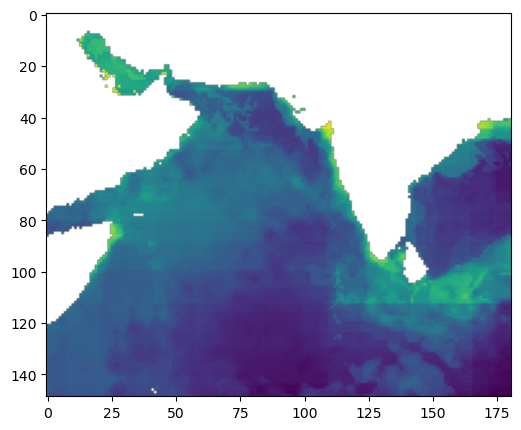

In [124]:
# Make a plot
plt.figure(figsize=(6,5))
land = (dataset["ocean_mask"].values == 0)
y_plot = np.where(land, np.nan, y_pred)
im = plt.imshow(y_plot, cmap="viridis")


In our example, we know the true log CHL since we sampled our training data from that. Let's show the true map against the predicted map. The `predict_and_plot_date` function is in our `ml_utils.py` file. It add bells and whistles and puts the true plot to the left.

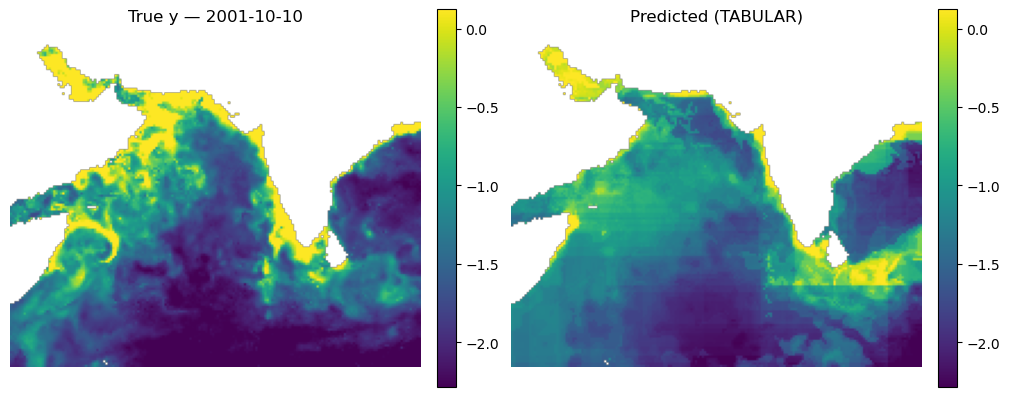

In [86]:
_ = mu.predict_and_plot_date(
    data_xr=dataset,
    date="2001-10-10",
    model=brt,
    num_var=num_var,
    cat_var=cat_var,
    X_mean=None, X_std=None,
    model_type="tabular",
    use_percentiles=True
)

### Plot for one day each month

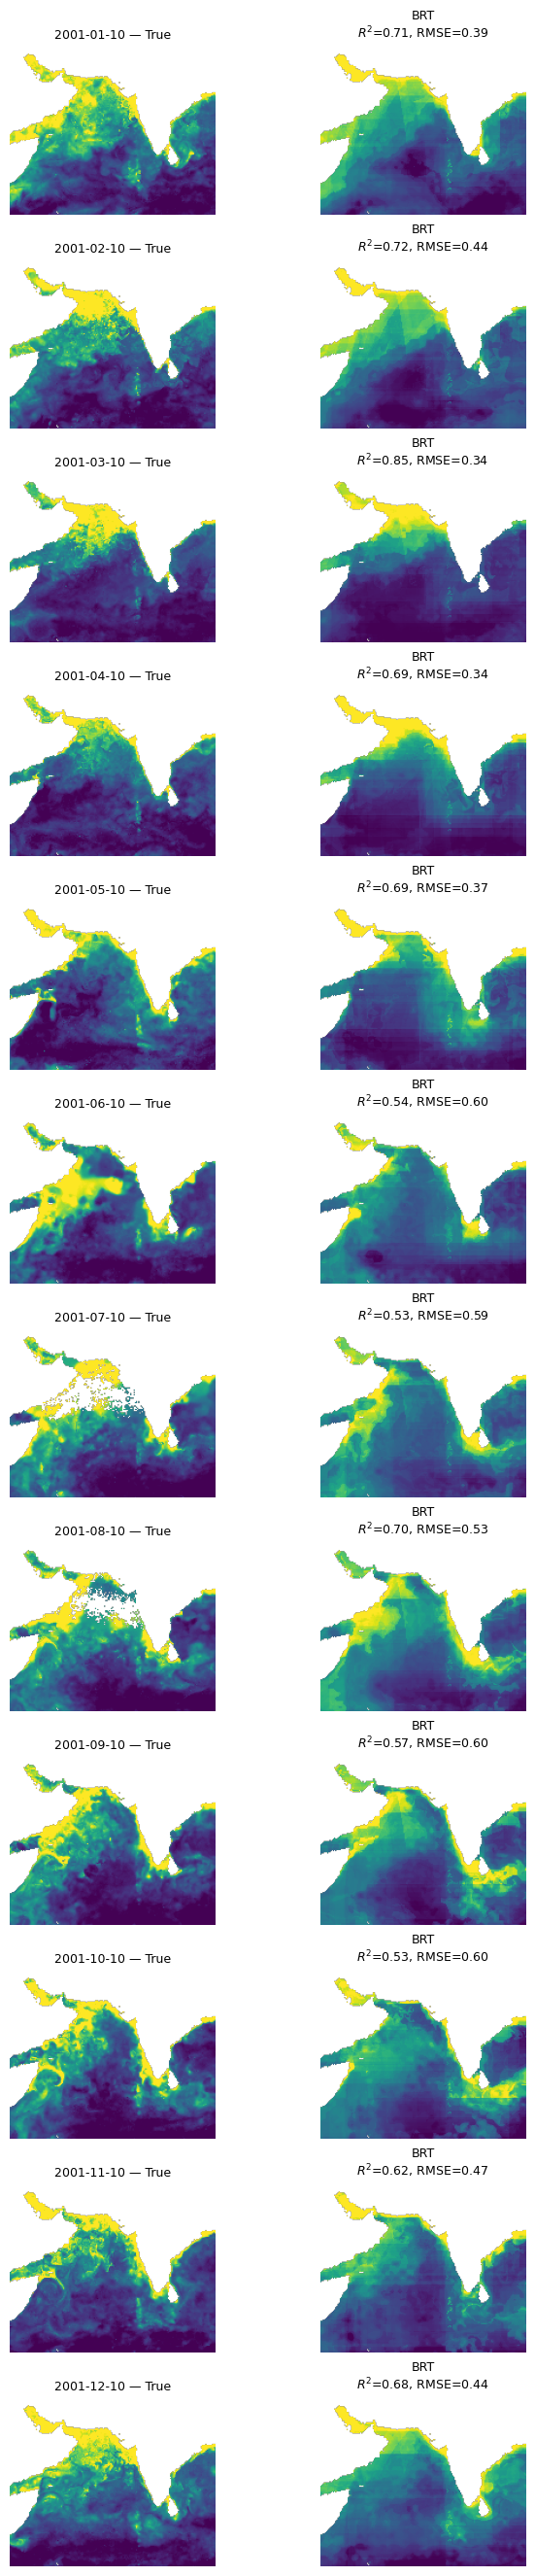

In [69]:
mu.plot_true_vs_predicted_year_multi(
    dataset, "2001", [brt_model], None, None, 
    num_var, cat_var, y_var="y", day=10,
    model_types=["tabular"],
    model_names=["BRT"])

## Summary

You have fit a basic BRT with season and location information. It is a bit "stripy" which happens with location variables but it is not terrible.

Things you might try
* remove salinity and sst
* keep salinity and sst and remove season or location variables
* reduce the number of sample points from 10,000 to 1,000